# Classification and prediction
Zhixing He 12-4-18   
This notebook is used to classify severity of the Virginia car crashes

In [1]:
#############################################
# Initialization
#############################################
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold

from lightgbm import plot_tree
from sklearn.metrics import confusion_matrix
from numpy import interp

In [2]:
#############################################
# Basic analysis
#############################################
class basic_analysis():
    def df_info(df):
        # show severity value counts
        print('Severity counts:\n', df['severity'].value_counts(), '\n')
        # show features
        print('Feature names: \n', df.columns)
        
    def plot_corr_matrix(df):
        # plot correlation matrix
        correlation = df.corr()
        plt.figure(figsize=(12,12))
        sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='viridis')

        plt.title('Correlation between different fearures')
    def time_analysis(df):
        # plot histogram of time (hour) for different severity
        bins=[i for i in range(24)]
        histtotal, bin_edges = np.histogram(df['hour'], bins = bins)
        plt.title("hour Histogram total")
        plt.xlabel('time (hour)')
        plt.ylabel('count')
        plt.bar(bin_edges[:-1], histtotal, width = 1)
        plt.show() 
        
        plt.figure(figsize=(14,6))
        for i in range(1, 6):
            x = df[df['severity'] == i]['hour']
            hist, bin_edges = np.histogram(x, bins = bins)
            plt.subplot(2, 3, i)
            plt.bar(bin_edges[:-1], hist/histtotal, width = 1)
            plt.title("severity " + str(i))
        plt.show()

In [3]:
# import dataframe
df=pd.read_csv('./Virginia_Crashes.csv')
df['hour']=(round(df['hour'])).astype('int')

basic_analysis.df_info(df)

Severity counts: 
 5    503629
2    272869
4      8813
1      4024
3       579
Name: severity, dtype: int64 

Feature names: 
 Index(['collision', 'weather', 'vehicles', 'light', 'surface', 'location',
       'relation', 'hour', 'second', 'year', 'severity', 'ped_injury',
       'ped_fatality', 'total_injury', 'total_fatality', 'work_zone',
       'school_zone', 'route', 'district', 'minus', 'index'],
      dtype='object')


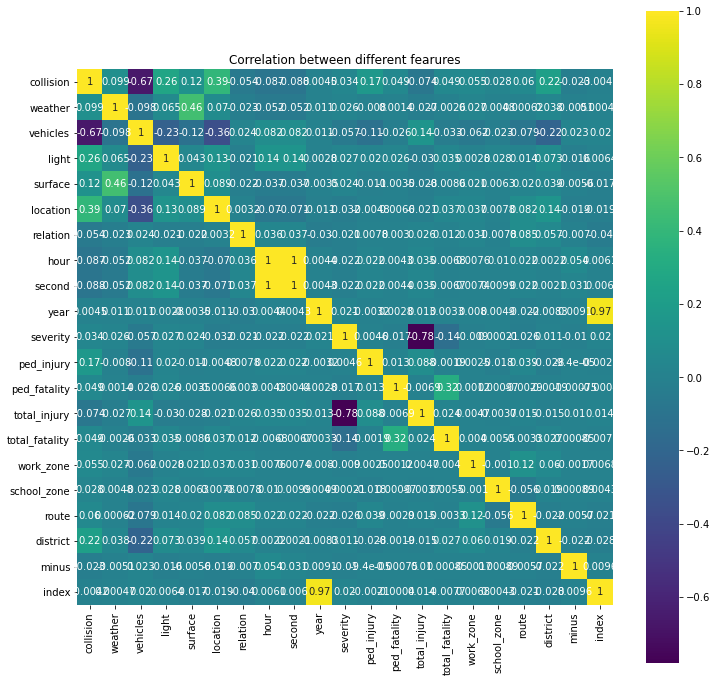

In [4]:
basic_analysis.plot_corr_matrix(df)

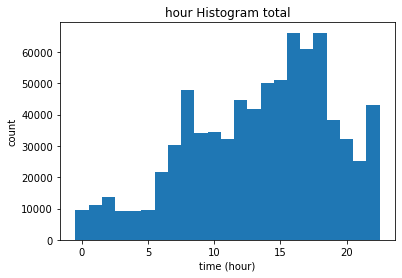

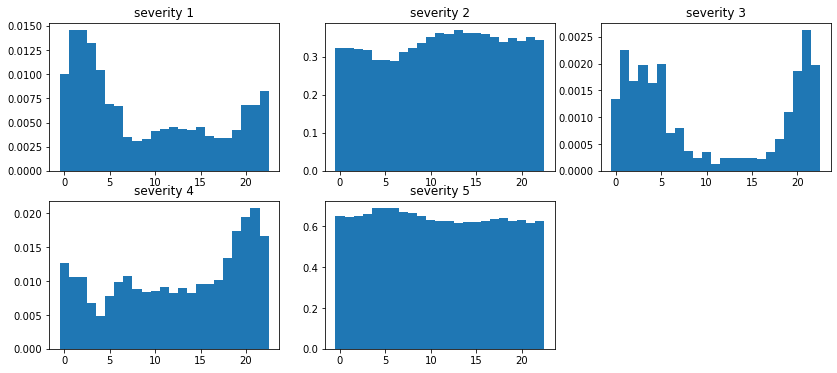

In [5]:
basic_analysis.time_analysis(df)

In [6]:
##########################
# preprocess class
#########################
class crash_process():
    def __init__(self, feats, class_names, categorical_columns):
        self.feats = feats
        self.class_names = class_names
        self.categorical_columns = categorical_columns
        
    # One-hot encoding for categorical columns with get_dummies, get binary attributes
    def one_hot_encoder(self, df, nan_as_category = True):
        original_columns = list(df.columns)
    #     categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    #     df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
        df = pd.get_dummies(df, columns= self.categorical_columns, dummy_na= nan_as_category)
        new_columns = [c for c in df.columns if c not in original_columns]
        return df, new_columns
    
    def preprocess(self, df, fraction = 0.8, seed = 110):
        # select features to be used
        df = df[self.feats]
        df = df[~(df['severity']== 5)]
        df, cat_cols = self.one_hot_encoder(df)
        #sample 20% dataset as test dataset
        df = df.sample(frac=1 , random_state = seed)
        train_df, test_df = df.iloc[:round(fraction*df.shape[0]),:], df.iloc[round(fraction*df.shape[0]):,:]
        return [train_df, test_df]
        ## saving training file and testing file
        # train_df.to_csv('./esemble/train_df.csv', index= False)
        # test_df.to_csv('./esemble/test_df.csv', index= False)

In [7]:
## run preprocess
feats = ['weather', 'light', 'surface','location','hour', 'severity', 'school_zone', 'route','index']
#        'work_zone','vehicles', 'relation','district','second','minus', 'year']
class_names = ['severity_1.0', 'severity_2.0','severity_3.0', 'severity_4.0']
#               , 'severity_5.0']
categorical_column = ['weather', 'light', 'surface','school_zone', 'route','severity','location']

cr = crash_process(feats, class_names, categorical_column)
train_df, test_df = cr.preprocess(df)

In [8]:
##########################
# lgbm training class
#########################
## using lgbm
## include n fold crossvalidation, plotting roc curve and feature importance
## change scale_pos_weight for different class, 
##  severity_4:45, severity_3:800, severity_2:0.04, severity_1:500

class lightgbm_crash():
    def __init__(self, target_class):
        self.class_names= target_class
    
    # Function for ploting feature importance
    def display_importances(self, feature_importance_df_, class_name):
        cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:10].index
        best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
        plt.figure(figsize=(8, 10))
        sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False),ci=None)
        plt.title(class_name+' Features (avg over folds)')
        plt.tight_layout
        plt.savefig('importances.png')
        
    # Function for ploting auc roc curve
    def display_roc_curve(self, y_, oof_preds_, folds_idx_):
        # Plot ROC curves
        plt.figure(figsize=(6,6))
        scores = []
        fprs=[]
        tprs=[]
        base_fpr = np.linspace(0, 1, 101)
        for n_fold, (_, val_idx) in enumerate(folds_idx_):  
            # Plot the roc curve
            fpr, tpr, thresholds = roc_curve(y_.iloc[val_idx], oof_preds_[val_idx])
            score = roc_auc_score(y_.iloc[val_idx], oof_preds_[val_idx])
            scores.append(score)
            plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.4f)' % (n_fold + 1, score))
            tpr = interp(base_fpr, fpr, tpr)
            tpr[0] = 0.0
            tprs.append(tpr)


        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)

        tprs = np.array(tprs)
        mean_tprs = tprs.mean(axis=0)
        std = tprs.std(axis=0)

        tprs_upper = np.minimum(mean_tprs + std, 1)
        tprs_lower = mean_tprs - std


        plt.plot(base_fpr, mean_tprs, 'b',label='Avg ROC (AUC = %0.4f $\pm$ %0.4f)' % (np.mean(scores), np.std(scores)),
                 lw=2, alpha=.8)
        plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

    #     plt.plot(np.mean(fprs), np.mean(tprs), color='b',
    #              label='Avg ROC (AUC = %0.4f $\pm$ %0.4f)' % (np.mean(scores), np.std(scores)),
    #              lw=2, alpha=.8)

        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('LightGBM ROC Curve')
        plt.legend(loc="lower right")
        plt.tight_layout()

        plt.savefig('roc_curve.png')
        
    def kfold_lightgbm(self, train_df, test_df, num_folds = 5):
        # Cross validation model
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=110)

        # Create arrays and dataframes to store results
        feats = [f for f in train_df.columns if f not in ['severity_1.0', 'severity_2.0',
           'severity_3.0', 'severity_4.0', 'severity_5.0', 'severity_nan','index']]

        oof_df=train_df[['index']].copy()
        sub_df = test_df[['index']].copy()
        for class_name in self.class_names:
            print("Class %s scores : " % class_name)
            oof_preds = np.zeros(train_df.shape[0])
            sub_preds = np.zeros(test_df.shape[0])
            feature_importance_df = pd.DataFrame()

            for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats],train_df[class_name])):
                dtrain = lgb.Dataset(data=train_df[feats].iloc[train_idx], 
                                     label=train_df[class_name].iloc[train_idx],free_raw_data=False)
                dvalid = lgb.Dataset(data=train_df[feats].iloc[valid_idx], 
                                     label=train_df[class_name].iloc[valid_idx],free_raw_data=False)

                params =  {  
    #                 'num_leaves': 15,
    #                 'max_depth': 7,
                    'objective': 'binary',
                    'boosting_type': 'gbdt',
                    'nthread': 4,
                    'learning_rate': 0.02,
                    'seed': 110,
                    'verbose': -1,
                    'metric': 'auc',
                    'scale_pos_weight':500
    #                 'class_weight':'balanced'
                }
                clf = lgb.train(
                    params=params,
                    train_set=dtrain,
                    num_boost_round=3000,
                    valid_sets=[dtrain, dvalid],
                    early_stopping_rounds=100,
                    verbose_eval=-1
                )

                oof_preds[valid_idx] = clf.predict(dvalid.data)
                sub_preds += clf.predict(test_df[feats]) / folds.n_splits

                fold_importance_df = pd.DataFrame()
                fold_importance_df["feature"] = feats
                fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
                fold_importance_df["fold"] = n_fold + 1
                feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
                print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(train_df[class_name].iloc[valid_idx], oof_preds[valid_idx])))

            # plot decision tree

    #         plot_tree(clf,figsize=(200,200))
    #         plt.savefig('tree.png')

            #get full auc score and confusion matrix for training and testing
            print('\n train Full AUC score %.6f' % roc_auc_score(train_df[class_name], oof_preds))
            print(' test Full AUC score %.6f' % roc_auc_score(test_df[class_name], sub_preds))

            oof_df[class_name] = oof_preds

            # Write submission file and plot feature importance

            sub_df[class_name] = sub_preds
            self.display_importances(feature_importance_df,class_name)
            folds_idx = [(trn_idx, val_idx) for trn_idx, val_idx in folds.split(train_df[feats],train_df[class_name])]
            self.display_roc_curve(y_=train_df[class_name], oof_preds_=oof_preds, folds_idx_=folds_idx)

            sub_preds=np.around(sub_preds).astype('int')
            oof_preds=np.around(oof_preds).astype('int')

            print('\n training confusion_matrix: \n',confusion_matrix(train_df[class_name], oof_preds))
            print('\n testing confusion_matrix: \n',confusion_matrix(test_df[class_name],sub_preds))
        #save predict results 
    #     oof_df.to_csv('./esemble/lgbseed110_oof.csv', index= False)
    #     sub_df.to_csv('./esemble/lgbseed110_sub.csv', index= False)
        return sub_df




Class severity_1.0 scores : 
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[124]	training's auc: 0.748046	valid_1's auc: 0.7268
Fold  1 AUC : 0.726800
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[44]	training's auc: 0.747246	valid_1's auc: 0.718999
Fold  2 AUC : 0.718999
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[32]	training's auc: 0.744277	valid_1's auc: 0.721322
Fold  3 AUC : 0.721322
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[88]	training's auc: 0.754588	valid_1's auc: 0.699745
Fold  4 AUC : 0.699745
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[6]	training's auc: 0.735429	valid_1's auc: 0.716271
Fold  5 AUC : 0.716271

 train Full AUC score 0.580190
test Full AUC score 0.697463

 training confusion_matrix: 
 [[124833 10

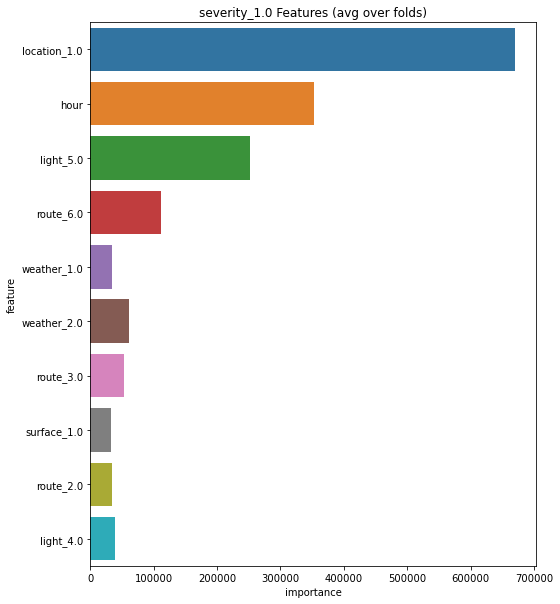

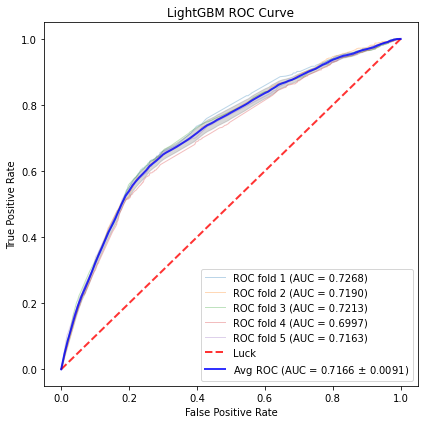

In [9]:
## run lgbm model
target_class = ['severity_1.0'] # Fatality
model = lightgbm_crash(target_class)
output = model.kfold_lightgbm(train_df, test_df)